<a href="https://colab.research.google.com/github/fbertran/m2csmi/blob/master/Digue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openturns

    100% |████████████████████████████████| 28.6MB 624kB/s 


In [0]:
import openturns as ot
import random
import math
from math import sqrt

from matplotlib import pyplot as plt
from openturns.viewer import View
ot.RandomGenerator.SetSeed(0)



#When the river height exceeds that of the dyke, flooding occurs.

####################
# Flooding function
####################

#def flooding(X):
#    Hd = 3.0
#    Zb = 55.5
#    L = 5.0e3
#    B = 300.0
#    Zd = Zb + Hd
#    Q, Ks, Zv, Zm = X
#    alpha = (Zm - Zv) / L
#    H = (Q / (Ks * B * alpha**0.5))**0.6
#    Zc = H + Zv
#    S = Zc - Zd
#    return [S]
# myFunction = ot.PythonFunction(4, 1, flooding)


def flooding_python(x) :
#  Q, Ks, Zv, Zm, Hd, Cb, L, B = x
  Q=x[0]
  if Q<500.:
    Q=500.
  elif Q>3000.:
    Q=3000.
  Ks=x[1]
  if Ks<15.:
    Ks=15.
  Zv=x[2]
  Zm=x[3]
  Hd=x[4]
  Cb=x[5]
  L=x[6]
  B=x[7]
  H = (Q/(B*Ks*sqrt((Zm-Zv)/L)))**0.6
  S = Zv + H - Hd - Cb
  return [S]

# Use that function defined in the script python
# with the openturns library
flooding = ot.PythonFunction(8,1,flooding_python)


In [0]:
####################
# Cost function
####################

def cost_python(x) :
#  Q, Ks, Zv, Zm, Hd, Cb, L, B = x
  Q=x[0]
  Ks=x[1]
  Zv=x[2]
  Zm=x[3]
  Hd=x[4]
  Cb=x[5]
  L=x[6]
  B=x[7]
  S = flooding(x)[0];
  Cp = 0.
  if S>0.:
    Cp += 1.
  else:
    Cp += 0.2 + 0.8*(1-math.exp(-1000/S**4))
  if Hd>8.:
    Cp += Hd/20.
  else:
    Cp += 8./20.
  return [Cp]

cost = ot.PythonFunction(8,1,cost_python)


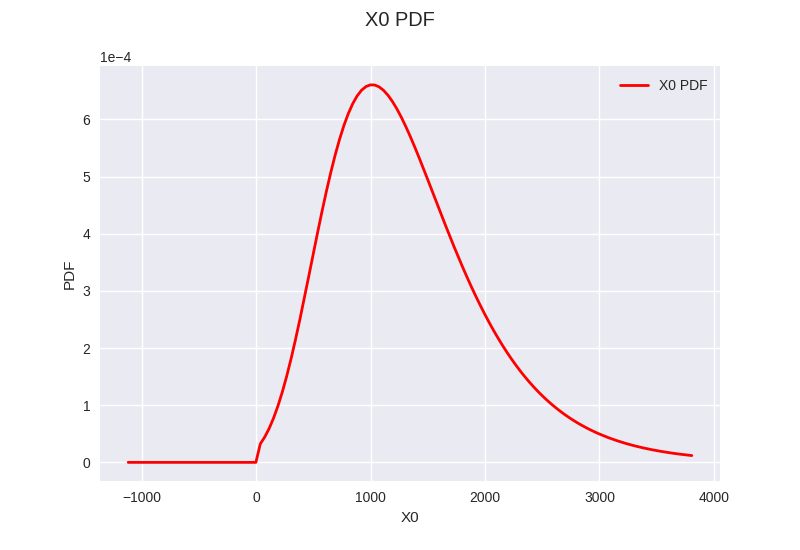

In [20]:
#######################
### Input random vector
#######################

myParam = ot.GumbelAB(1013.0, 558.0)
distributionQ = ot.ParametrizedDistribution(myParam)
distributionQ = ot.TruncatedDistribution(distributionQ, 0.0, ot.SpecFunc.MaxScalar)
distributionKs = ot.Normal(30.0, 8.)
distributionKs = ot.TruncatedDistribution(distributionKs, 0.0, ot.SpecFunc.MaxScalar)
distributionZv = ot.Triangular(49.,50.,51.)
distributionZm = ot.Triangular(54.,55.,56.)
distributionHd = ot.Uniform(1.,2.)
distributionCb = ot.Triangular(55.,55.5,56.)
distributionL = ot.Triangular(4990.,5000.,5010.)
distributionB = ot.Triangular(295.,300.,305.)
distributionQ.drawPDF()



In [0]:
collectionMarginals = [distributionQ,distributionKs,distributionZv,distributionZm,distributionHd,distributionCb,distributionL,distributionB]
aCopula = ot.IndependentCopula(len(collectionMarginals))
aCopula.setName("Independent copula")

inputDistribution = ot.ComposedDistribution(collectionMarginals, ot.Copula(aCopula))
inputDistribution.setDescription(("Q","Ks","Zv","Zm","Hd","Cb","L","B"))

inputRandomVector = ot.RandomVector(inputDistribution)
inputRandomVector.setDescription(("Q","Ks","Zv","Zm","Hd","Cb","L","B"))

outputS = ot.RandomVector(flooding, inputRandomVector)
outputCp = ot.RandomVector(cost, inputRandomVector)

In [8]:
###############################
# a) Probabilite de flooding
##############################

ot.RandomGenerator.SetSeed(random.randint(1,100))

myEvent = ot.Event(outputS, ot.Greater(), 0.0)
myEvent.setName("Flooding!")

print("################")
print("Monte Carlo")
print("################")
print("")

maximumOuterSampling = 100000
blockSize = 1
coefficientOfVariation = 0.1

# Creation de l'algorithme Monte Carlo
experiment = ot.MonteCarloExperiment()
algoMC = ot.ProbabilitySimulationAlgorithm(myEvent,experiment)
algoMC.setMaximumOuterSampling(maximumOuterSampling)
algoMC.setBlockSize(blockSize)
algoMC.setMaximumCoefficientOfVariation(coefficientOfVariation)

algoMC.setConvergenceStrategy(ot.Full())
# For statistics about the algorithm
initialNumberOfCall = flooding.getEvaluationCallsNumber()


algoMC.run()

result = algoMC.getResult()
print("MC estimate of the probability of flooding : ", result.getProbabilityEstimate())
print("Variance of the MC estimator : ", result.getVarianceEstimate())
print('CV =', result.getCoefficientOfVariation())
#print('MonteCarlo result=', result)
print('Number of executed iterations =', result.getOuterSampling())
print('Number of calls to the flooding function =', flooding.getEvaluationCallsNumber() - initialNumberOfCall)


################
Monte Carlo
################

MC estimate of the probability of flooding :  0.00028000000000000545
Variance of the MC estimator :  2.7992160000000535e-09
CV = 0.18895577713921582
Number of executed iterations = 100000
Number of calls to the flooding function = 100000


         [ Q         Ks        Zv        ... Cb        L         B         ]
     0 : [ 1185.86     27.6901   49.2518 ...   55.5161 5007.35    304.073  ]
     1 : [  883.849    31.6249   50.3331 ...   55.3326 4994.9     301.054  ]
     2 : [  479.137    37.5235   49.2394 ...   55.2029 5007.21    299.573  ]
...
179997 : [  730.94     25.7787   49.7607 ...   55.3667 4996.47    299.935  ]
179998 : [ 2739.85     35.6813   50.5957 ...   55.7492 5001.34    301.892  ]
179999 : [  490.465    24.6586   50.2447 ...   55.437  4993.75    300.946  ]
         [ y0       ]
     0 : [ -5.7839  ]
     1 : [ -4.17615 ]
     2 : [ -6.71268 ]
...
179997 : [ -5.62693 ]
179998 : [ -3.34684 ]
179999 : [ -5.07315 ]
For the flooding:
First Order Sobol Indices:  [0.512774,0.192273,0.211216,0.0149574,0.0852342,0.0404916,0.0101033,0.0103215]
Total Order Sobol Indices:  [0.50009,0.18453,0.199668,0.001814,0.0780012,0.0396442,-5.07349e-06,4.95907e-05]


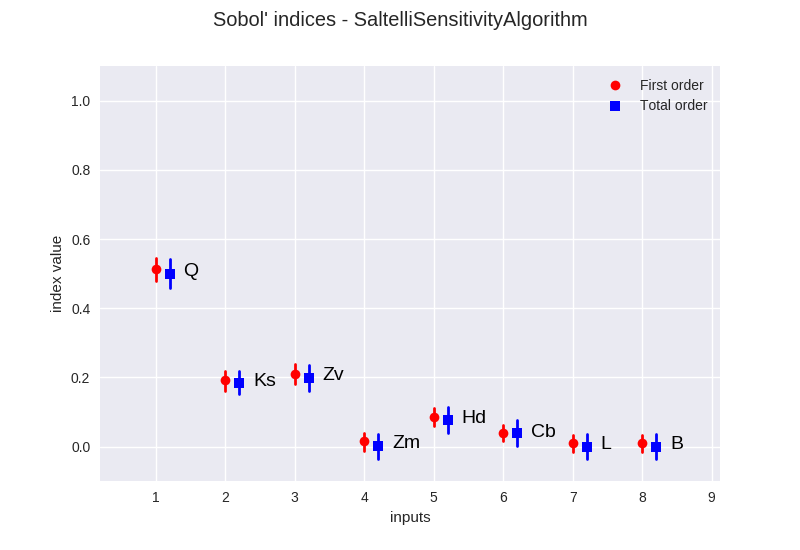

In [25]:
################################
# b) Sobol Indices
################################



size = 10000
computeSO = True

###For the Flooding
inputDesignS = ot.SobolIndicesExperiment(inputDistribution, size, computeSO).generate()
print(inputDesignS)
outputDesignS = flooding(inputDesignS)
print(outputDesignS)

sensitivityAnalysisS = ot.SaltelliSensitivityAlgorithm(inputDesignS, outputDesignS, size)

#First order Sobol indices
print("For the flooding:")
print("First Order Sobol Indices: ", sensitivityAnalysisS.getFirstOrderIndices())
#Total order Sobol indices
print("Total Order Sobol Indices: ", sensitivityAnalysisS.getTotalOrderIndices())

sensitivityAnalysisS.draw()

#Graph file
#graph = sensitivityAnalysisS.draw()

#fig = plt.figure(figsize=(8, 4))
#plt.suptitle(graph.getTitle())
#axis = fig.add_subplot(111)
#axis.set_xlim(auto=True)
#View(graph, figure=fig, axes=[axis], add_legend=True)



For the cost:
First Order Sobol Indices: [0.432225,0.104533,0.213051,0.00062203,0.0772784,0.0379873,-0.00268846,-0.00284458]
Total Order Sobol Indices:  [0.519261,0.153112,0.286137,0.00338467,0.117911,0.0592068,-3.62771e-06,8.94279e-05]


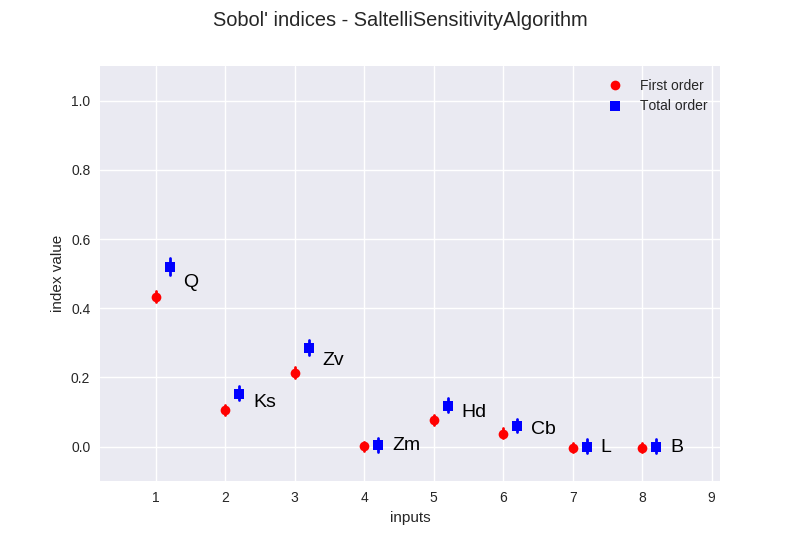

In [12]:
###For the cost
size = 30000

#True -> calcul indices second ordre
inputDesignCp = ot.SobolIndicesExperiment(inputDistribution, size, True).generate()
outputDesignCp = cost(inputDesignCp)
sensitivityAnalysisCp = ot.SaltelliSensitivityAlgorithm(inputDesignCp, outputDesignCp, size)

#First order Sobol indices
print("For the cost:")
print("First Order Sobol Indices:", sensitivityAnalysisCp.getFirstOrderIndices())
#Total order Sobol indices
print("Total Order Sobol Indices: ", sensitivityAnalysisCp.getTotalOrderIndices())

#Second order Sobol indices
print("Second Order Sobol Indices: ", sensitivityAnalysisCp.getSecondOrderIndices())


#Graph file
sensitivityAnalysisCp.draw()

In [16]:
#Second order Sobol indices
print("Second Order Sobol Indices: ", sensitivityAnalysisCp.getSecondOrderIndices())


Second Order Sobol Indices:  8x8
[[  0           0.0187218   0.0404529  -0.00233427  0.0135702   0.0039853  -0.00249214 -0.00235931 ]
 [  0.0187218   0           0.0158256   0.00523581  0.00982586  0.00724554  0.00538104  0.00541565 ]
 [  0.0404529   0.0158256   0           0.00751468  0.0132844   0.0099052   0.0079959   0.00804941 ]
 [ -0.00233427  0.00523581  0.00751468  0           0.00520291  0.00514886  0.00477339  0.0047684  ]
 [  0.0135702   0.00982586  0.0132844   0.00520291  0           0.00953064  0.00838697  0.0084389  ]
 [  0.0039853   0.00724554  0.0099052   0.00514886  0.00953064  0           0.0058179   0.00582909 ]
 [ -0.00249214  0.00538104  0.0079959   0.00477339  0.00838697  0.0058179   0           0.00536689 ]
 [ -0.00235931  0.00541565  0.00804941  0.0047684   0.0084389   0.00582909  0.00536689  0          ]]


In [0]:
##########################
# c) Metamodel
##########################

#A LatinHyperSquare should be used instead of random points.
X = inputRandomVector.getSample(100)
dim = X.getDimension()

Y1 = flooding(X)
Y2 = cost(X)

#Just one of the possible covariance model
covarianceModel = ot.SquaredExponential(dim)

basis = ot.ConstantBasisFactory(dim).build()

algoS = ot.KrigingAlgorithm(X, Y1, covarianceModel, basis)
algoCp = ot.KrigingAlgorithm(X, Y2, covarianceModel, basis)

algoS.run()
algoCp.run()
resultS = algoS.getResult()
resultCp = algoCp.getResult()
metamodelS = resultS.getMetaModel()
metamodelCp = resultCp.getMetaModel()

In [18]:
Xtest = inputRandomVector.getSample(10)
print("For Flooding with 10 random test points")
print("With metamodel:")
print(metamodelS(Xtest))
print("True value: ")
print(flooding(Xtest))

For Flooding with 10 random test points
With metamodel:
    [ y0       ]
0 : [ -5.54313 ]
1 : [ -6.46586 ]
2 : [ -4.9334  ]
3 : [ -4.86536 ]
4 : [ -4.04216 ]
5 : [ -5.00321 ]
6 : [ -4.73349 ]
7 : [ -3.99611 ]
8 : [ -3.42016 ]
9 : [ -4.97134 ]
True value: 
    [ y0       ]
0 : [ -5.46303 ]
1 : [ -6.45387 ]
2 : [ -4.98581 ]
3 : [ -4.83419 ]
4 : [ -4.08838 ]
5 : [ -5.06825 ]
6 : [ -4.72834 ]
7 : [ -4.01396 ]
8 : [ -3.30923 ]
9 : [ -4.95866 ]


In [0]:
Xtest = inputRandomVector.getSample(10)
print("For Cost with 10 random test points")
print("With metamodel:")
print(metamodelCp(Xtest))
print("True value: ")
print(cost(Xtest))

For Cost with 10 random test points
With metamodel:
    [ y0       ]
0 : [ 0.650476 ]
1 : [ 0.67873  ]
2 : [ 0.662581 ]
3 : [ 0.666265 ]
4 : [ 0.657425 ]
5 : [ 0.679035 ]
6 : [ 0.66326  ]
7 : [ 0.672528 ]
8 : [ 0.685022 ]
9 : [ 0.636711 ]
True value: 
    [ y0       ]
0 : [ 0.650679 ]
1 : [ 0.678557 ]
2 : [ 0.65426  ]
3 : [ 0.662232 ]
4 : [ 0.654966 ]
5 : [ 0.676839 ]
6 : [ 0.664928 ]
7 : [ 0.672206 ]
8 : [ 0.686835 ]
9 : [ 0.641921 ]
